In [1]:
import os, sys
import pandas as pd
import pickle
from os.path import dirname, abspath
d = os.path.abspath(os.path.join('..'))
sys.path.append(d)
from model_trial import Experiment
from util.file_processor import FileProcessor
from sklearn.metrics import mean_absolute_error
from sklearn import tree
import seaborn as sns
import matplotlib
matplotlib.rcParams.update({'font.size': 8, 'figure.figsize' : [1.5*3.125, 1.5*1.5],
                           'legend.fontsize': 10, 'legend.fancybox': True,
                           'font.family': 'serif', 'font.sans-serif': 'Times',
                            'xtick.major.width': 0.2, 'xtick.minor.width': 2*0.2,
                            'ytick.major.width': 0.2, 'ytick.minor.width': 2*0.2,
                            'text.usetex': False, 'axes.labelsize': 7*2
                           })
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
import numpy as np
import re
import graphviz
import pathlib

In [2]:
%run '../util/webrtc_reader.py'
%run '../util/helper_functions.py'
%run '../util/pcap2csv.py'

In [3]:
data_dir = "../../data/netrics_beta"

In [47]:
def get_file_tuples():
    ls = []
    for f in os.listdir(f'{data_dir}'):
        p = f'{data_dir}/{f}/tmp/Data'
        vca = os.listdir(p)[0]
        print(p)
        # convert(f'{p}/{vca}')
        try:
            pcap = [x for x in os.listdir(f'{p}/{vca}') if x.endswith('.pcap')][0]
            pcap = f'{p}/{vca}/{pcap}'
        except IndexError:
            print(f'PCAP file missing for {p}/{vca}')
        try:
            csv = [x for x in os.listdir(f'{p}/{vca}') if x.endswith('.csv')][0]
            csv = f'{p}/{vca}/{csv}'
        except IndexError:
            print(f'CSV file missing for {p}/{vca}')
        try:
            webrtc = [x for x in os.listdir(f'{p}/{vca}') if x.endswith('.json')][0]
            webrtc = f'{p}/{vca}/{webrtc}'
        except IndexError:
            print(f'WebRTC file missing for {p}/{vca}')
        ls.append((pcap, csv, webrtc))
    return ls

def get_webrtc_df(f):
    rdr = WebRTCReader(f)
    return rdr.get_webrtc()

In [48]:
files = get_file_tuples()

../../data/netrics_beta/nm_data_20230418_140831_vca_qoe_extra/tmp/Data
../../data/netrics_beta/nm_data_20230418_100826_vca_qoe_extra/tmp/Data
../../data/netrics_beta/nm_data_20230418_043846_vca_qoe_extra/tmp/Data
../../data/netrics_beta/nm_data_20230418_020825_vca_qoe_extra/tmp/Data
../../data/netrics_beta/nm_data_20230418_040826_vca_qoe_extra/tmp/Data
../../data/netrics_beta/nm_data_20230418_093847_vca_qoe_extra/tmp/Data
../../data/netrics_beta/nm_data_20230418_060825_vca_qoe_extra/tmp/Data
../../data/netrics_beta/nm_data_20230418_080830_vca_qoe_extra/tmp/Data
../../data/netrics_beta/nm_data_20230418_003847_vca_qoe_extra/tmp/Data
../../data/netrics_beta/nm_data_20230418_023847_vca_qoe_extra/tmp/Data
../../data/netrics_beta/nm_data_20230418_000825_vca_qoe_extra/tmp/Data
../../data/netrics_beta/nm_data_20230418_123846_vca_qoe_extra/tmp/Data
../../data/netrics_beta/nm_data_20230418_090824_vca_qoe_extra/tmp/Data
../../data/netrics_beta/nm_data_20230418_073847_vca_qoe_extra/tmp/Data
WebRTC

meet Duration > Num Vals ../../data/netrics_beta/nm_data_20230418_100826_vca_qoe_extra/tmp/Data/meet/client-meet-1681812425.json 6.022000074386597
teams Duration > Num Vals ../../data/netrics_beta/nm_data_20230418_093847_vca_qoe_extra/tmp/Data/teams/client-teams-1681810625.json 2.9769999980926514
teams Duration > Num Vals ../../data/netrics_beta/nm_data_20230418_023847_vca_qoe_extra/tmp/Data/teams/client-teams-1681785425.json 4.664000034332275
teams Duration > Num Vals ../../data/netrics_beta/nm_data_20230418_113846_vca_qoe_extra/tmp/Data/teams/client-teams-1681817825.json 4.270999908447266
teams Duration > Num Vals ../../data/netrics_beta/nm_data_20230418_033951_vca_qoe_extra/tmp/Data/teams/client-teams-1681789090.json 3.2350001335144043
no inbound stream
../../data/netrics_beta/nm_data_20230418_053847_vca_qoe_extra/tmp/Data/teams/client-teams-1681796226.json
teams Duration > Num Vals ../../data/netrics_beta/nm_data_20230418_133849_vca_qoe_extra/tmp/Data/teams/client-teams-1681825028.

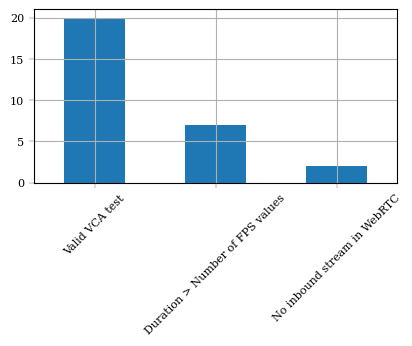

In [58]:
web_dfs = []
test_dfs = {'file': [], 'status': []}
for f in files:
    test_dfs['file'].append(f[2])
    if not os.path.exists(f[2]):
        test_dfs['status'].append('No WebRTC file found')
        continue
    df = get_webrtc_df(f[2])
    if len(df) == 0:
        print(f[2])
        test_dfs['status'].append('No inbound stream in WebRTC')
        continue
    df['pcap_file'] = f[0]
    df['csv_file'] = f[1]
    df['webrtc_file'] = f[2]
    if 'meet' in f[2]:
        vca = 'meet'
    elif 'teams' in f[2]:
        vca = 'teams'
    if int(df['duration'].max()) > df['num_vals'].max():
        print(vca, 'Duration > Num Vals', f[2], df['duration'].max() - df['num_vals'].max())
        test_dfs['status'].append('Duration > Number of FPS values')
        continue
    test_dfs['status'].append('Valid VCA test')
    df['vca'] = vca
    web_dfs.append(df)
df = pd.concat(web_dfs, axis=0)
tdf = pd.DataFrame(test_dfs)
tdf['status'].value_counts().plot.bar(rot=45)
plt.grid(visible=1)

In [57]:
tdf['status'].value_counts()

Valid VCA test                     20
Duration > Number of FPS values     7
No inbound stream in WebRTC         2
Name: status, dtype: int64

In [7]:
df

,ts,ssrc,lastPacketReceivedTimestamp,framesPerSecond,bitrate,[codec],packetsLost,framesDropped,framesReceived,framesReceivedPerSecond,...,framesDecodedPerSecond,jitterBufferEmittedCount,frameHeight,qpSum,duration,num_vals,pcap_file,csv_file,webrtc_file,vca
0,1681826878,2953878905,1.681827e+12,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.000000,...,0.000000,0.0,NaN,NaN,15.432,17,../../data/netrics_beta/nm_data_20230418_14083...,../../data/netrics_beta/nm_data_20230418_14083...,../../data/netrics_beta/nm_data_20230418_14083...,meet
1,1681826879,2953878905,1.681827e+12,NaN,6.977010e+05,NaN,0.0,3.0,30.0,23.854223,...,20.673660,25.0,NaN,NaN,15.432,17,../../data/netrics_beta/nm_data_20230418_14083...,../../data/netrics_beta/nm_data_20230418_14083...,../../data/netrics_beta/nm_data_20230418_14083...,meet
2,1681826880,2953878905,1.681827e+12,19.0,1.215653e+06,"VP9 (98, profile-id=0)",0.0,3.0,26.0,24.686317,...,24.686317,26.0,720.0,5160.0,15.432,17,../../data/netrics_beta/nm_data_20230418_14083...,../../data/netrics_beta/nm_data_20230418_14083...,../../data/netrics_beta/nm_data_20230418_14083...,meet
3,1681826881,2953878905,1.681827e+12,25.0,1.403488e+06,"VP9 (98, profile-id=0)",0.0,3.0,23.0,24.729431,...,24.729431,23.0,720.0,4264.0,15.432,17,../../data/netrics_beta/nm_data_20230418_14083...,../../data/netrics_beta/nm_data_20230418_14083...,../../data/netrics_beta/nm_data_20230418_14083...,meet
4,1681826882,2953878905,1.681827e+12,25.0,1.550349e+06,"VP9 (98, profile-id=0)",0.0,3.0,24.0,26.501088,...,24.292664,22.0,720.0,3410.0,15.432,17,../../data/netrics_beta/nm_data_20230418_14083...,../../data/netrics_beta/nm_data_20230418_14083...,../../data/netrics_beta/nm_data_20230418_14083...,meet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14,1681801688,2374209971,1.681802e+12,25.0,1.439510e+06,"VP9 (98, profile-id=0)",0.0,0.0,24.0,23.991168,...,24.990800,25.0,720.0,3809.0,18.186,19,../../data/netrics_beta/nm_data_20230418_07082...,../../data/netrics_beta/nm_data_20230418_07082...,../../data/netrics_beta/nm_data_20230418_07082...,meet
15,1681801689,2374209971,1.681802e+12,25.0,1.616907e+06,"VP9 (98, profile-id=0)",0.0,0.0,26.0,25.142571,...,25.142571,25.0,720.0,4159.0,18.186,19,../../data/netrics_beta/nm_data_20230418_07082...,../../data/netrics_beta/nm_data_20230418_07082...,../../data/netrics_beta/nm_data_20230418_07082...,meet
16,1681801690,2374209971,1.681802e+12,25.0,1.338044e+06,"VP9 (98, profile-id=0)",0.0,0.0,6.0,26.013097,...,26.013097,6.0,720.0,936.0,18.186,19,../../data/netrics_beta/nm_data_20230418_07082...,../../data/netrics_beta/nm_data_20230418_07082...,../../data/netrics_beta/nm_data_20230418_07082...,meet
17,1681801691,2374209971,1.681802e+12,26.0,1.496556e+06,"VP9 (98, profile-id=0)",0.0,0.0,27.0,25.419870,...,25.419870,27.0,720.0,4315.0,18.186,19,../../data/netrics_beta/nm_data_20230418_07082...,../../data/netrics_beta/nm_data_20230418_07082...,../../data/netrics_beta/nm_data_20230418_07082...,meet


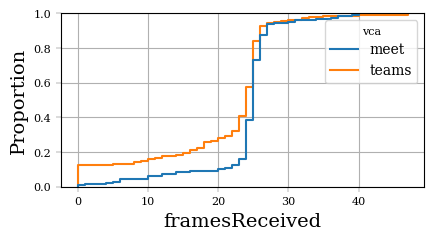

In [8]:
df = df.reset_index()
sns.ecdfplot(data=df, x = 'framesReceived', hue='vca')
plt.grid(visible=1)

In [9]:
df_meet = df[df['vca'] == 'meet']
df_teams = df[df['vca'] == 'teams']

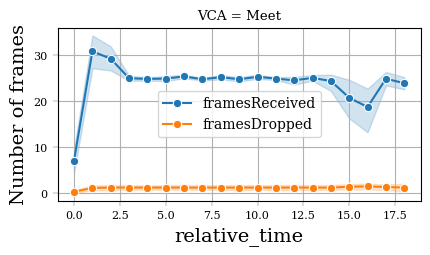

In [27]:
time_sorted = []
for f in df_meet['webrtc_file'].unique():
    d = df_meet[df_meet['webrtc_file'] == f]
    d = d.sort_values(by='ts')
    d['relative_time'] = d['ts'] - d['ts'].min()
    time_sorted.append(d)
dfm = pd.concat(time_sorted, axis=0)
sns.lineplot(data = dfm, x = 'relative_time', y = 'framesReceived', marker='o', label='framesReceived')
sns.lineplot(data = dfm, x = 'relative_time', y = 'framesDropped', marker='o', label='framesDropped')
plt.title('VCA = Meet')
plt.ylabel('Number of frames')
plt.grid(visible=1)

<AxesSubplot: xlabel='framesDropped', ylabel='Proportion'>

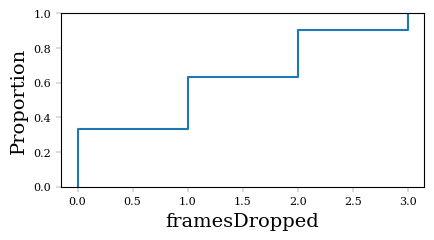

In [28]:
sns.ecdfplot(data=df_meet, x = 'framesDropped')

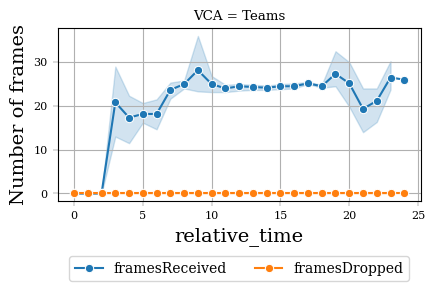

In [45]:
time_sorted = []
for f in df_teams['webrtc_file'].unique():
    d = df_teams[df_teams['webrtc_file'] == f]
    d = d.sort_values(by='ts')
    d['relative_time'] = d['ts'] - d['ts'].min()
    time_sorted.append(d)
dfm = pd.concat(time_sorted, axis=0)
sns.lineplot(data = dfm, x = 'relative_time', y = 'framesReceived', marker='o', label='framesReceived')
sns.lineplot(data = dfm, x = 'relative_time', y = 'framesDropped', marker='o', label='framesDropped')
plt.title('VCA = Teams')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5), ncol=2)
plt.ylabel('Number of frames')
plt.grid(visible=1)

<AxesSubplot: xlabel='framesDropped', ylabel='Proportion'>

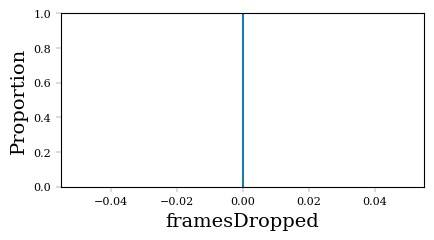

In [46]:
sns.ecdfplot(data=df_teams, x = 'framesDropped')

There's a dip in FPS for both VCAs near the end of the call. Is it an artifact of the test procedure / device compute / network conditions?

In [12]:
%run '../qoe_estimation/rtp/model.py'
%run '../qoe_estimation/frame_lookback/model.py'
from config import project_config

In [13]:
rtp_meet = RTPModel('meet', 'framesReceived')
rtp_teams = RTPModel('teams', 'framesReceived')

preds = []
for webrtc_file in df_meet['webrtc_file'].unique():
    d = df_meet[df_meet['webrtc_file'] == webrtc_file]
    p = list(d['pcap_file'].unique())[0]
    c = list(d['csv_file'].unique())[0]
    pred = rtp_meet.estimate((p, c, webrtc_file))
    preds.append(pred)
df_pred_meet = pd.concat(preds, axis=0)

preds = []
for webrtc_file in df_teams['webrtc_file'].unique():
    d = df_teams[df_teams['webrtc_file'] == webrtc_file]
    p = list(d['pcap_file'].unique())[0]
    c = list(d['csv_file'].unique())[0]
    pred = rtp_teams.estimate((p, c, webrtc_file))
    preds.append(pred)
df_pred_teams = pd.concat(preds, axis=0)

In [14]:
from sklearn.metrics import mean_absolute_error

print('Meet RTP Heuristic Error = ', round(mean_absolute_error(df_pred_meet['framesReceived_rtp'], df_pred_meet['framesReceived_gt']), 2))
print('Teams RTP Heuristic Error = ', round(mean_absolute_error(df_pred_teams['framesReceived_rtp'], df_pred_teams['framesReceived_gt']), 2))

Meet RTP Heuristic Error =  2.88
Teams RTP Heuristic Error =  3.31


In [15]:
from config import project_config

lookback_meet = FrameLookbackModel('meet', 'framesReceived', project_config)
lookback_teams = FrameLookbackModel('teams', 'framesReceived', project_config)

preds = []
for webrtc_file in df_meet['webrtc_file'].unique():
    d = df_meet[df_meet['webrtc_file'] == webrtc_file]
    p = list(d['pcap_file'].unique())[0]
    c = list(d['csv_file'].unique())[0]
    pred = lookback_meet.estimate((p, c, webrtc_file))
    preds.append(pred)
df_pred_meet = pd.concat(preds, axis=0)

preds = []
for webrtc_file in df_teams['webrtc_file'].unique():
    d = df_teams[df_teams['webrtc_file'] == webrtc_file]
    p = list(d['pcap_file'].unique())[0]
    c = list(d['csv_file'].unique())[0]
    pred = lookback_teams.estimate((p, c, webrtc_file))
    preds.append(pred)
df_pred_teams = pd.concat(preds, axis=0)

print('Meet IP/UDP Heuristic Error = ', round(mean_absolute_error(df_pred_meet['framesReceived_frame-lookback'], df_pred_meet['framesReceived_gt']), 2))
print('Teams IP/UDP Heuristic Error = ', round(mean_absolute_error(df_pred_teams['framesReceived_frame-lookback'], df_pred_teams['framesReceived_gt']), 2))

Meet IP/UDP Heuristic Error =  39.95
Teams IP/UDP Heuristic Error =  6.88
